# EDA On Wifire BP3D Runs Dataset
Key Questions: 
- What existing features are useful in predicting the run time of a wifire simulation? 
- What features can be created to assist in eventually training a prediction model?
- What is the correlation between different variables and runtime?

# Setup

In [49]:
from tqdm import tqdm
import pandas as pd
from pprint import pprint
from rich import print as show
from datetime import datetime, timedelta
import time
import seaborn as sns
import ast

In [50]:
simulation_runs = pd.read_csv("simulation_runs.csv")
simulation_runs

,Unnamed: 0,path,time_scraped,canopy_moisture,dz,extent,extent_fmt,fire_grid,fuel,ignition,...,run_max_mem_rss_bytes,run_start,seed,sim_time,surface_moisture,threads,timestep,topo,wind_direction,wind_speed
0,38,burnpro3d/d/00/60/run_00601423-00ba-4edc-85de-...,2023-07-27T17:04:03.155927,1.00,NaN,"[-928246.0, 1477596.0, -927440.0, 1476900.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,1934680,2023-06-20T15:13:20.118932-07:00,-1,4503,0.10,1,600,"{'topo_calcs': True, 'total_startup_iters': 500}",65.0,2.235
1,41,burnpro3d/d/00/6d/run_006d5586-0a9c-448a-b307-...,2023-07-27T17:04:03.155927,0.90,NaN,"[-2022346.0, 1581420.0, -2020914.0, 1580036.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,2470180,2023-06-15T11:08:55.640920-07:00,-1,11382,0.05,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",90.0,4.470
2,77,burnpro3d/d/00/d5/run_00d57d95-2227-40ea-b1a8-...,2023-07-27T17:04:03.155927,0.95,NaN,"[-2011072.0, 1581140.0, -2010524.0, 1580484.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,517424,2023-06-27T16:04:29.825894-07:00,-1,3937,0.12,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",270.0,2.235
3,10,burnpro3d/d/01/37/run_0137bb44-361e-48ed-8feb-...,2023-07-27T17:05:28.453250,1.10,NaN,"[885288.0, 870390.0, 886242.0, 869286.0]","[[x1, y1], [x2, y2]]",NaN,"{'density': None, 'dx': 2, 'dy': 2, 'height': ...","{'dat': None, 'id': '121dc89e-b034-479a-b0da-c...",...,2454040,2023-04-09T18:24:10.951246-07:00,-1,4921,0.10,1,600,NaN,137.0,3.000
4,14,burnpro3d/d/01/40/run_0140601b-6702-452f-8bc0-...,2023-07-27T17:05:28.453250,1.00,NaN,"[-2097480.0, 2037504.0, -2096674.0, 2036700.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,3919432,2023-06-20T09:53:36.922562-07:00,-1,14997,0.15,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",360.0,4.470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801,933,burnpro3d/d/06/8c/run_068c457c-a424-4ff3-88c3-...,2023-07-28T14:10:38.603030,1.20,NaN,"[-2022368.0, 1580996.0, -2021710.0, 1580178.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,646732,2023-07-13T13:06:05.502941-07:00,-1,5295,0.07,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",200.0,1.341
1802,952,burnpro3d/d/06/b6/run_06b68a07-2e40-48f0-bd71-...,2023-07-28T14:10:38.603030,1.00,NaN,"[-2022346.0, 1581420.0, -2020914.0, 1580036.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,2468564,2023-06-14T12:24:02.976749-07:00,-1,11359,0.10,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",150.0,2.235
1803,956,burnpro3d/d/06/bc/run_06bc4ffe-9e1a-4ec3-954d-...,2023-07-28T14:10:38.603030,1.00,NaN,"[123782.0, 1223754.0, 124586.0, 1222950.0]","[[x1, y1], [x2, y2]]",NaN,NaN,NaN,...,2461908,2023-07-21T13:15:51.249485-07:00,-1,5918,0.15,1,600,"{'topo_calcs': False, 'total_startup_iters': 500}",60.0,6.705
1804,970,burnpro3d/d/06/f0/run_06f03978-c4af-4efa-b6a4-...,2023-07-28T14:10:38.603030,1.00,NaN,"[-1959092.0, 1310426.0, -1958552.0, 1309880.0]","[[x1, y1], [x2, y2]]",NaN,"{'density': None, 'dx': 2, 'dy': 2, 'height': ...","{'dat': None, 'id': '6d7c8d09-bd6c-4d7e-a642-9...",...,436472,2023-05-12T10:58:25.077365-07:00,-1,4157,0.12,1,600,NaN,10.0,2.000


In [51]:

def calculate_area(str):
    #where p1 in the bottom left = (x1,y1) and p2 in the bottom left = (x2,y2)
    L = ast.literal_eval(str)
    x1, y1, x2, y2 = float(L[0]), float(L[1]), float(L[2]), float(L[3])
    
    area = (x2-x1) * (y2-y1)
    return abs(area)


# DataFrame Reshaping
add area column generated from `extent` and only extract relevant columns

In [52]:
useful_columns = [
    "path",
    "sim_time",
    "run_end",
    "run_start",
    "extent",
    "surface_moisture",
    "timestep",
    "wind_direction",
    "wind_speed",
    "canopy_moisture"
]
run_data = simulation_runs.get(useful_columns)
column = run_data.apply(lambda row: calculate_area(row["extent"]), axis=1)
run_data = run_data.assign(area=column)
run_data.head()

,path,sim_time,run_end,run_start,extent,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,area
0,burnpro3d/d/00/60/run_00601423-00ba-4edc-85de-...,4503,2023-06-20T16:44:36.032464-07:00,2023-06-20T15:13:20.118932-07:00,"[-928246.0, 1477596.0, -927440.0, 1476900.0]",0.10,600,65.0,2.235,1.00,560976.0
1,burnpro3d/d/00/6d/run_006d5586-0a9c-448a-b307-...,11382,2023-06-15T13:51:13.573728-07:00,2023-06-15T11:08:55.640920-07:00,"[-2022346.0, 1581420.0, -2020914.0, 1580036.0]",0.05,600,90.0,4.470,0.90,1981888.0
2,burnpro3d/d/00/d5/run_00d57d95-2227-40ea-b1a8-...,3937,2023-06-27T16:12:51.127014-07:00,2023-06-27T16:04:29.825894-07:00,"[-2011072.0, 1581140.0, -2010524.0, 1580484.0]",0.12,600,270.0,2.235,0.95,359488.0
3,burnpro3d/d/01/37/run_0137bb44-361e-48ed-8feb-...,4921,2023-04-09T19:36:16.198481-07:00,2023-04-09T18:24:10.951246-07:00,"[885288.0, 870390.0, 886242.0, 869286.0]",0.10,600,137.0,3.000,1.10,1053216.0
4,burnpro3d/d/01/40/run_0140601b-6702-452f-8bc0-...,14997,2023-06-20T12:23:45.540506-07:00,2023-06-20T09:53:36.922562-07:00,"[-2097480.0, 2037504.0, -2096674.0, 2036700.0]",0.15,600,360.0,4.470,1.00,648024.0


In [53]:
print(len(run_data['path'].unique()))
len(run_data)

1572


1806

<Axes: xlabel='area', ylabel='sim_time'>

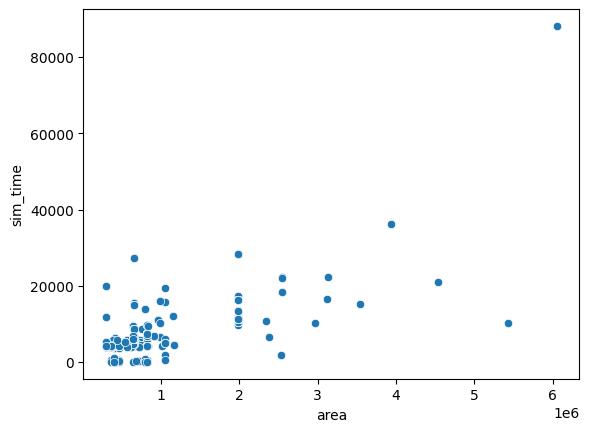

In [54]:
sns.scatterplot(x=run_data['area'], y=run_data['sim_time'])

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


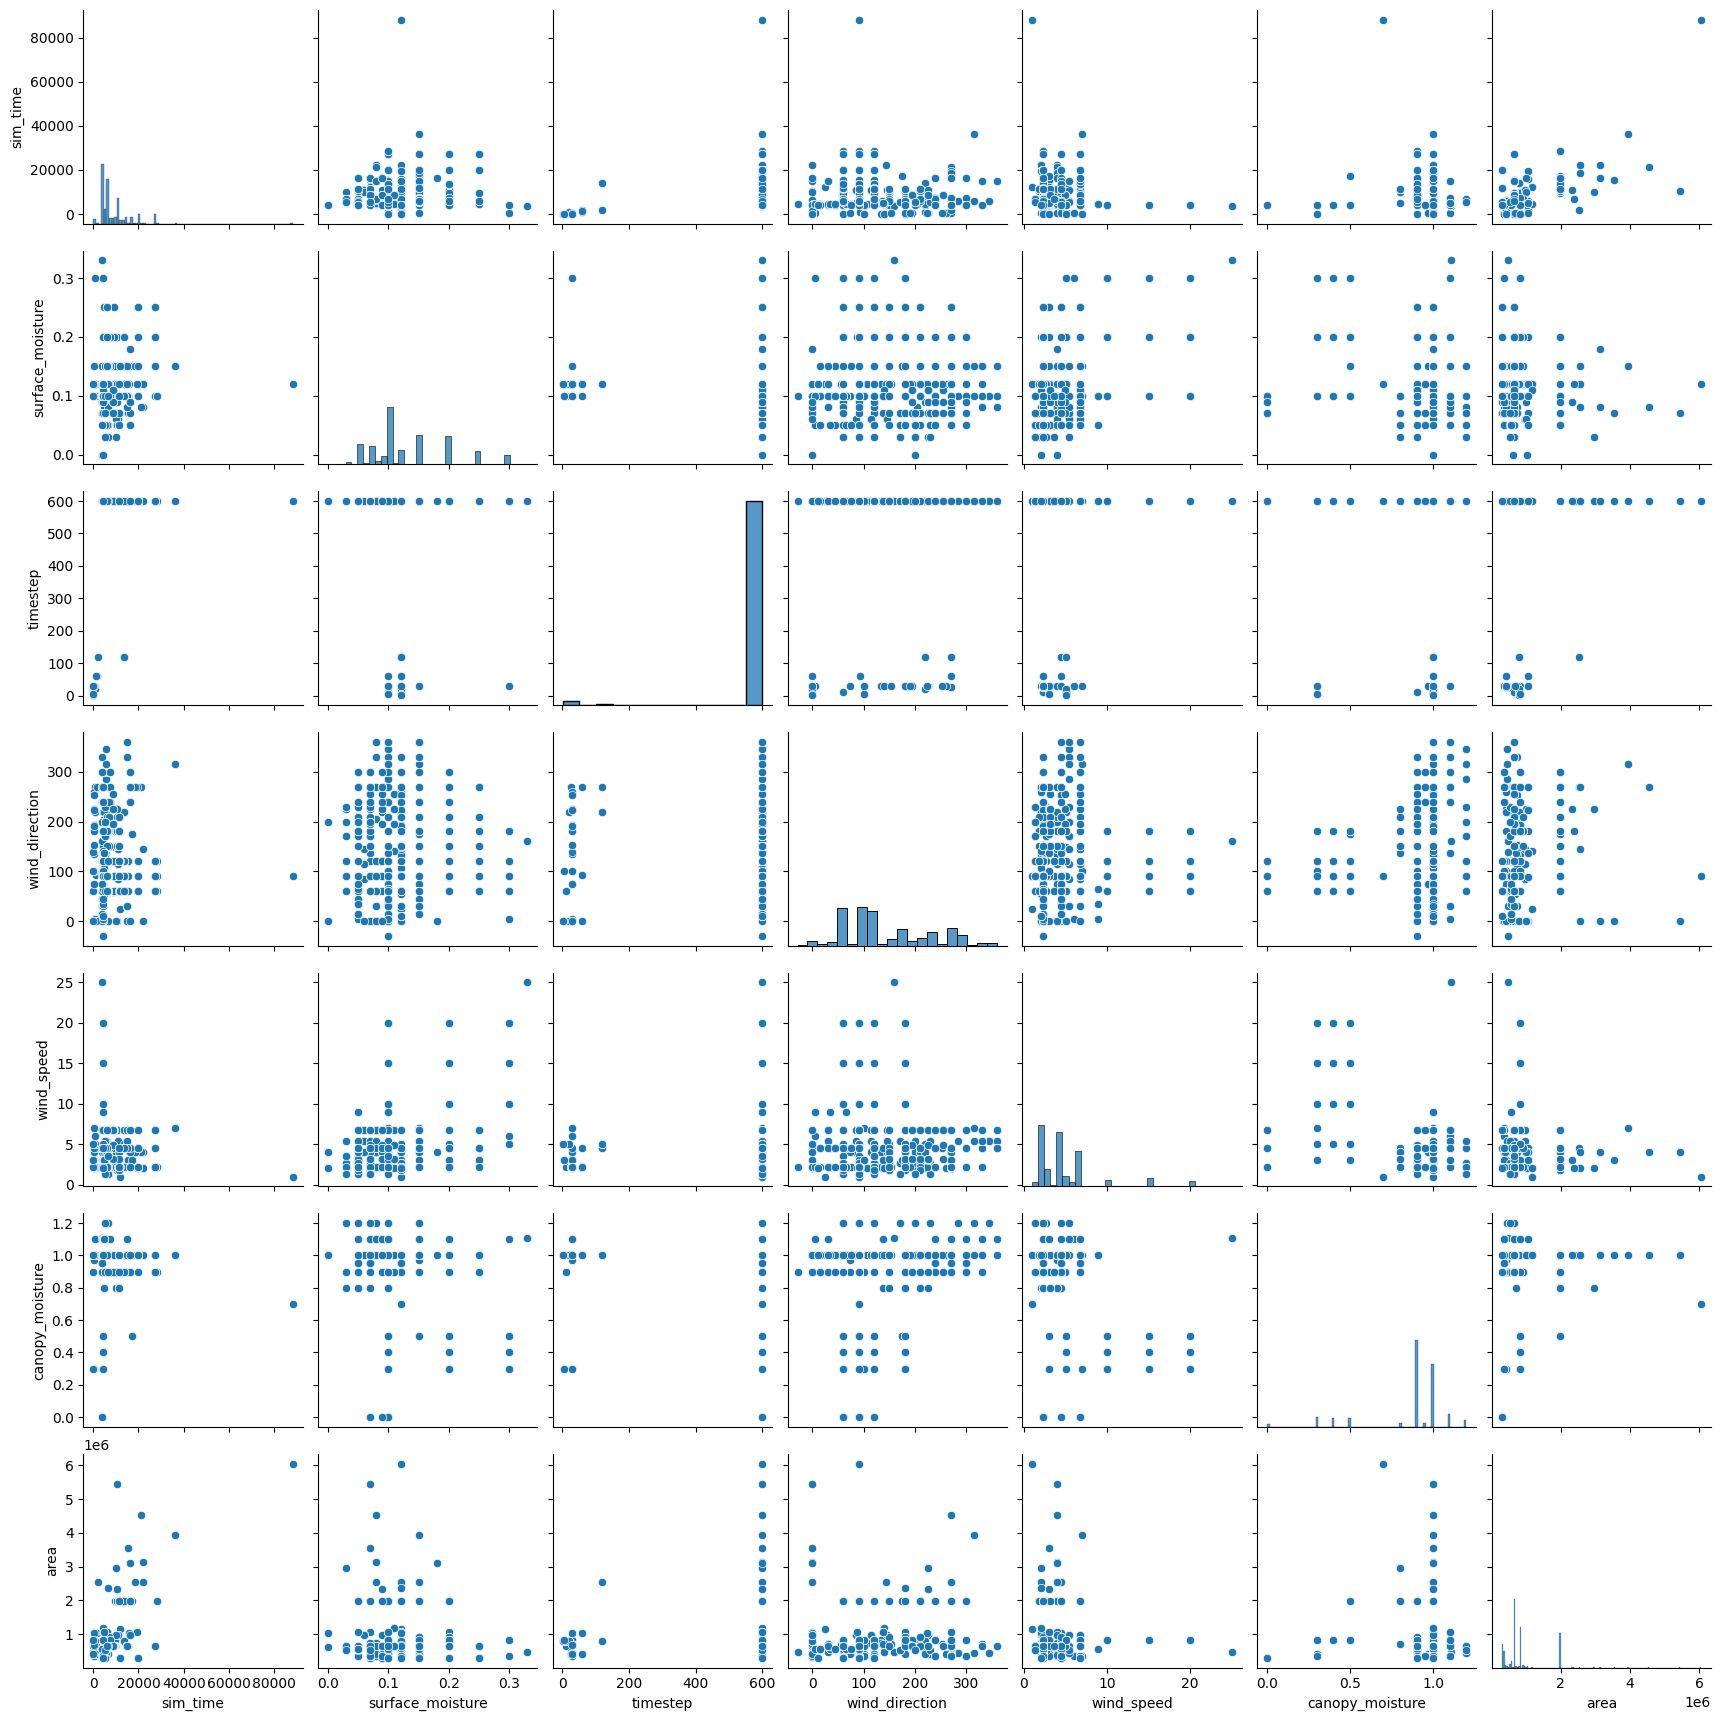

In [55]:
sns.pairplot(run_data)

# K means clustering

In [770]:
print(test_y.head())
test_X.head()

      sim_time
1606     14997
1607     27251
1608     16374
1609      5983
1610      5945


,area,surface_moisture,wind_direction,wind_speed,canopy_moisture
1606,648024.0,0.15,360.0,4.470,1.0
1607,648024.0,0.25,90.0,2.235,0.9
1608,1981888.0,0.05,270.0,2.235,1.0
1609,648024.0,0.15,180.0,4.470,0.9
1610,646416.0,0.10,120.0,6.705,1.0


In [758]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.metrics as sm

In [759]:
df = run_data[:1600] # only look at a little bit of data for now

X = df.get(['area','surface_moisture','wind_direction','wind_speed','canopy_moisture'])
y = pd.DataFrame(df['sim_time'], columns=['sim_time'])

In [760]:
n_clusters = 30
model = KMeans(n_clusters=n_clusters)
model.fit(X)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=30)

In [769]:
from random import randint
print(x)
tdf = run_data[-200:]
test_X = tdf.get(['area','surface_moisture','wind_direction','wind_speed','canopy_moisture'])
test_y = pd.DataFrame(tdf['sim_time'], columns=['sim_time'])


1500


In [762]:
prediction = model.predict(test_X)

In [763]:
test_y["sim_time"] = (test_y["sim_time"] / test_y["sim_time"].max()) * n_clusters

test_y
d = pd.DataFrame({},columns=["answer","prediction"])
d["answer"] = test_y
d["prediction"] = prediction
d["difference"] = abs(d["answer"] - d["prediction"])


In [764]:
accuracy = 1 - (d["difference"].sum() / len(d) / n_clusters) 
print(f"{round(accuracy * 100,1)}% accurate")

74.7% accurate


In [765]:
len(run_data)

1806